In [1]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import copy
import h5py
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from biosppy.signals import ecg
from biosppy.signals.tools import filter_signal
from scipy.signal import iirnotch

# IPython imports
from IPython.display import Image
%matplotlib inline

In [3]:
DATA_DIRECTORY = '/mnt/disks/ecg-bike-tensors-2/2019-09-17/'
# DATA_DIRECTORY = '/Users/pbatra/broad/local_data_sets/tensors/test/ecg-rest-and-bike-with-trend-tensors/'
all_sample_ids = [samp[:-4] for samp in os.listdir(DATA_DIRECTORY) if 'hd5' in samp]


sampling_rate = 500.
def exercise_ecg_by_sample_id(sample_id):
    out = {}
    with h5py.File(os.path.join(DATA_DIRECTORY, f'{sample_id}.hd5'), 'r') as hd5:
        if 'ecg_bike_recovery' not in hd5.keys():
            return
        trends = hd5['ecg_bike_trend']
        rest_start_idx = list(trends['PhaseName']).index(2)
        out['full_times'] = np.array(list(trends['time']))
        out['full_hrs'] = np.array(list(trends['HeartRate']))
        out['full_loads'] = np.array(list(trends['Load']))
        
        
        out['times'] = np.array(list(trends['PhaseTime'])[rest_start_idx:])
        signal_length=30000
        out['ts_reference'] = np.array([i*1./(sampling_rate+1.) for i in range(0,signal_length)])
        out['hrs'] = np.array(list(trends['HeartRate'])[rest_start_idx:])
        out['loads'] = np.array(list(trends['Load'])[rest_start_idx:])
        out['artifacts'] = np.array(list(trends['Artifact']))                          
        for lead in list(hd5['ecg_bike_recovery'].keys()):
            out[lead] = np.array(hd5['ecg_bike_recovery'][lead])
            out[f'{lead}_filtered'], _, _= filter_signal(signal=np.array(out[lead]),
                                          ftype='FIR',
                                          band='bandpass',
                                          order=int(0.3 * sampling_rate),
                                          frequency=[.9, 50], #3,45
                                          sampling_rate=sampling_rate)
        out['max_hr'] = list(hd5['continuous']['bike_max_hr'])[0]
        out['resting_hr'] = list(hd5['continuous']['bike_resting_hr'])[0]
        out['max_pred_hr'] = list(hd5['continuous']['bike_max_pred_hr'])[0]
        out['hr_recovery_60s'] = out['max_hr'] - out['hrs'][-1]
        out['hr_increase'] = out['max_hr'] - out['resting_hr']
        out['max_hr_achieved_ratio'] = out['max_hr'] / out['max_pred_hr']
        out['pred_peak_exercise'] = out['max_pred_hr'] - out['resting_hr']
        out['peak_hr_reserve'] = out['max_hr'] / out['pred_peak_exercise']
    return out

In [4]:
all_sample_ids[2]

'3391312'

In [8]:
exercise_ecg_by_sample_id(all_sample_ids[1])

TypeError: 'NoneType' object is not subscriptable

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


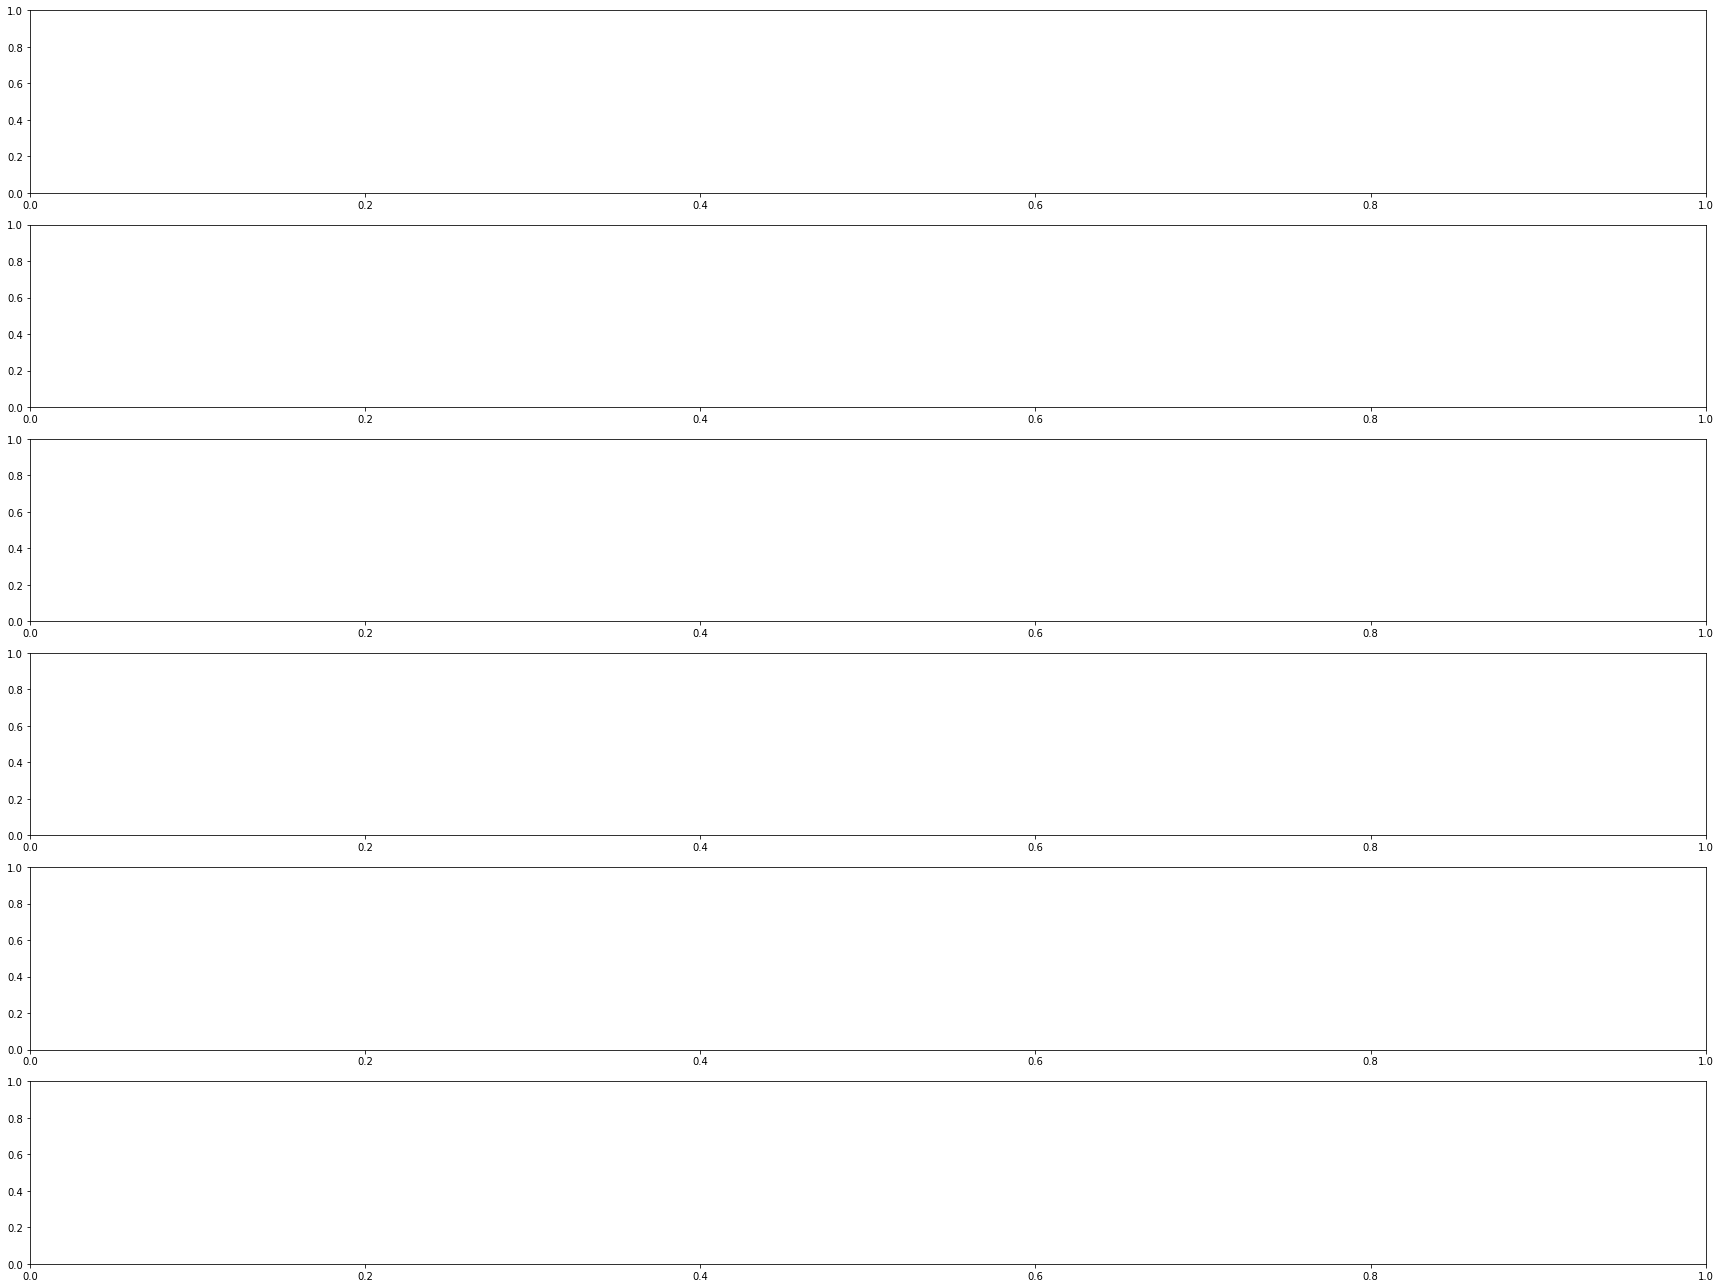

In [6]:
sec_per_box = 0.04
mv_per_box = .1
time_interval = 2.5 #time-interval per plot in seconds. ts_Reference data is in s, voltage measurement is 5 uv per lsb
raw_scale = 0.005 # convert to mV

def plot_exercise_ecg(sample_id):
    time_interval = 2.0
    fig, ax = plt.subplots(nrows=6, ncols=1, sharey='row', figsize=(24,18), tight_layout=True)
    out = exercise_ecg_by_sample_id(sample_id)
    leads = np.array([out['lead_I'], out['lead_2'], out['lead_3']])
    leads_filtered=np.array([out['lead_I_filtered'], out['lead_2_filtered'], out['lead_3_filtered']])
    #leads -= leads.mean(axis=1)[: ,np.newaxis]
    #leads /= leads.std(axis=1)[: ,np.newaxis]
    ax[0].set_xlim(4.0, 4.0+time_interval)
    ax[0].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
    ax[0].xaxis.set_minor_locator(AutoMinorLocator(5))
    ax[0].grid(which='major', color='#CCCCCC', linestyle='--')
    ax[0].grid(which='minor', color='#CCCCCC', linestyle=':')
    ax[0].plot(out['times'],out['hrs'], color='green')
    for i in range(1,4):
            ax[i].set_xlim(4.0,4.0+time_interval)
            ax[i].set_ylim(-1.5, 1.5) #-1.5mV -> 1.5mV
            ax[i].xaxis.set_major_locator(MultipleLocator(0.2)) #major grids at every .2sec = 5 * 0.04 sec
            ax[i].yaxis.set_major_locator(MultipleLocator(0.5))  #major grids at every .5mV 

            ax[i].xaxis.set_minor_locator(AutoMinorLocator(5))
            ax[i].yaxis.set_minor_locator(AutoMinorLocator(5))

            ax[i].grid(which='major', color='#CCCCCC', linestyle='--')
            ax[i].grid(which='minor', color='#CCCCCC', linestyle=':')

            #normalize data in muv
            #ax[i].plot(out['ts_reference'], [elem_ * raw_scale for elem_ in leads[i-1]], color='green')
            ax[i].plot(out['ts_reference'], [elem_ * raw_scale for elem_ in leads_filtered[i-1]], color='red')
    #plot_resting_ecg(leads[:, :500 * 10])
    ax[4].plot(out['full_times'], out['full_hrs'], label='hr')
    ax[5].plot(out['full_times'], out['full_loads'], label='load')
    plt.show()
    
plot_exercise_ecg(all_sample_ids[1])

In [ ]:
all_outs = []
for i, s in enumerate(all_sample_ids):
    out = exercise_ecg_by_sample_id(s)
    
    if out:
        all_outs.append(out)
        del out['hrs']
    print(f"{i}",end="\r")
all_metrics_df = pd.DataFrame(all_outs)

In [ ]:
all_metrics_df = pd.DataFrame(all_outs)

In [ ]:
plt.figure(figsize=(20, 10))
for i, col in enumerate(['max_hr', 'resting_hr', 'max_pred_hr','hr_recovery_60s','hr_increase','max_hr_achieved_ratio','pred_peak_exercise','peak_hr_reserve']):
    plt.subplot(4, 2, i + 1)
    plt.hist(all_metrics_df[col], bins=50)
    plt.title(f'{col} mean {all_metrics_df[col].mean():.2f}, std {all_metrics_df[col].std():.2f}')
plt.tight_layout()
plt.show()

In [ ]:
len(['max_hr', 'resting_hr', 'max_pred_hr','hr_recovery_60s','hr_increase','max_hr_achieved_ratio','pred_peak_exercise','peak_hr_reserve'])

In [ ]:
all_metrics_df.std()

In [ ]:
all_metrics_df.columns